## S4

Data source Spain's National Statistics Institute (INE) on tourism activity
https://www.ine.es/dynt3/inebase/index.htm?padre=239

Business Question:  
Adjust business strategy (pricing, promotions, services) based on tourism trends from INE (Spain’s National Statistics Institute) to better match traveler demand.  

• Is it necessary to adjust our offerings to the traveler profile and the demand for overnight stays in the cities where we are present, considering the official figures on origin, months of visit, and average overnight stays per autonomous city?

https://www.ine.es/jaxiT3/Tabla.htm?t=2941&L=0

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ruta del archivo
file_path = r"../Data/INE_Encuesta_de_ocupación_hotelera_2074.csv"

# Leer el archivo CSV correctamente
df = pd.read_csv(file_path, sep=";", encoding="utf-8-sig")

# Mostrar las primeras filas para verificar
print(df.head())

  Totales Territoriales Comunidades y Ciudades Autónomas Provincias  \
0        Total Nacional                              NaN        NaN   
1        Total Nacional                              NaN        NaN   
2        Total Nacional                              NaN        NaN   
3        Total Nacional                              NaN        NaN   
4        Total Nacional                              NaN        NaN   

  Viajeros y pernoctaciones Residencia: Nivel 1 Residencia: Nivel 2  Periodo  \
0                   Viajero               Total                 NaN  2025M02   
1                   Viajero               Total                 NaN  2025M01   
2                   Viajero               Total                 NaN  2024M12   
3                   Viajero               Total                 NaN  2024M11   
4                   Viajero               Total                 NaN  2024M10   

        Total  
0   6.539.960  
1   5.776.075  
2   6.553.489  
3   7.171.221  
4  10.774.30

C:\Users\lasso\AppData\Local\Temp\ipykernel_2216\1027460593.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8-sig")


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131880 entries, 0 to 131879
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Totales Territoriales             131880 non-null  object
 1   Comunidades y Ciudades Autónomas  129996 non-null  object
 2   Provincias                        94200 non-null   object
 3   Viajeros y pernoctaciones         131880 non-null  object
 4   Residencia: Nivel 1               131880 non-null  object
 5   Residencia: Nivel 2               87920 non-null   object
 6   Periodo                           131880 non-null  object
 7   Total                             131870 non-null  object
dtypes: object(8)
memory usage: 8.0+ MB


In [30]:
df

,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,Periodo,Total
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M02,6.539.960
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M01,5.776.075
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M12,6.553.489
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M11,7.171.221
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M10,10.774.309
...,...,...,...,...,...,...,...,...
131875,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M05,1.305
131876,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M04,1.668
131877,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M03,1.673
131878,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,1999M02,1.487


In [31]:
# Get distinct values and their counts for each column (from 2022 onwards)
print("Distinct value counts for each column (from 2022):\n")
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False), "\n")

Distinct value counts for each column (from 2022):

Column: Totales Territoriales
Totales Territoriales
Total Nacional    131880
Name: count, dtype: int64 

Column: Comunidades y Ciudades Autónomas
Comunidades y Ciudades Autónomas
07 Castilla y León                18840
01 Andalucía                      16956
08 Castilla - La Mancha           11304
09 Cataluña                        9420
12 Galicia                         9420
16 País Vasco                      7536
10 Comunitat Valenciana            7536
02 Aragón                          7536
05 Canarias                        5652
11 Extremadura                     5652
06 Cantabria                       3768
04 Balears, Illes                  3768
03 Asturias, Principado de         3768
13 Madrid, Comunidad de            3768
14 Murcia, Región de               3768
15 Navarra, Comunidad Foral de     3768
17 Rioja, La                       3768
18 Ceuta                           1884
NaN                                1884
19 Melill

In [32]:
# Group by CCAA and Provincias, count occurrences
group_ccaa_prov = df.groupby(['Comunidades y Ciudades Autónomas', 'Provincias']).size().reset_index(name='Count')

# Show first few rows
print(group_ccaa_prov.head())

# Save to CSV
group_ccaa_prov.to_csv('group_ccaa_prov.csv', index=False, encoding='utf-8-sig')

  Comunidades y Ciudades Autónomas  Provincias  Count
0                     01 Andalucía  04 Almería   1884
1                     01 Andalucía    11 Cádiz   1884
2                     01 Andalucía  14 Córdoba   1884
3                     01 Andalucía  18 Granada   1884
4                     01 Andalucía   21 Huelva   1884


In [33]:
# Clean and convert 'Total' column to float
df['Total'] = (
    df['Total']
    .astype(str)
    .str.replace('.', '', regex=False)
    .replace('', np.nan)
    .astype(float)
)

# Drop rows with Totals for both travellers origen and rename
df = df.dropna(subset=['Residencia: Nivel 2'])
df = df.rename(columns={'Residencia: Nivel 2': 'Traveler Origin'})

# Drop column same value for all rows
df = df.drop(columns=['Residencia: Nivel 1'])



In [34]:
# Define full province names
target_provinces = [
    "29 Málaga",
    "41 Sevilla",
    "07 Balears, Illes",
    "08 Barcelona",
    "17 Girona",
    "46 Valencia/València",
    "28 Madrid"
]

# Clean 'Provincias' column
df['Provincias'] = df['Provincias'].astype(str).str.strip()

# Apply both filters sequentially on df
df_filtered = df[
    df['Provincias'].isin(target_provinces) &
    (df['Periodo'].str[:4].astype(int) >= 2022)
].copy()


In [35]:
df_filtered

,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Traveler Origin,Periodo,Total
15386,Total Nacional,01 Andalucía,29 Málaga,Viajero,Residentes en España,2025M02,153408.0
15387,Total Nacional,01 Andalucía,29 Málaga,Viajero,Residentes en España,2025M01,97146.0
15388,Total Nacional,01 Andalucía,29 Málaga,Viajero,Residentes en España,2024M12,120354.0
15389,Total Nacional,01 Andalucía,29 Málaga,Viajero,Residentes en España,2024M11,141204.0
15390,Total Nacional,01 Andalucía,29 Málaga,Viajero,Residentes en España,2024M10,164584.0
...,...,...,...,...,...,...,...
108991,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Pernoctaciones,Residentes en el Extranjero,2022M05,1110766.0
108992,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Pernoctaciones,Residentes en el Extranjero,2022M04,1023461.0
108993,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Pernoctaciones,Residentes en el Extranjero,2022M03,815168.0
108994,Total Nacional,"13 Madrid, Comunidad de",28 Madrid,Pernoctaciones,Residentes en el Extranjero,2022M02,588508.0


In [36]:
# Separate into travelers and overnight stays
df_travelers = df_filtered[df_filtered['Viajeros y pernoctaciones'] == 'Viajero'].copy()
df_stays = df_filtered[df_filtered['Viajeros y pernoctaciones'] == 'Pernoctaciones'].copy()

# Rename 'Total' to reflect its meaning in each DataFrame
df_travelers.rename(columns={'Total': 'Total Travelers'}, inplace=True)
df_stays.rename(columns={'Total': 'Total Overnight Stays'}, inplace=True)

for d in [df_travelers, df_stays]:
    d['Year'] = d['Periodo'].str[:4].astype(int)
    d['Month'] = d['Periodo'].str[5:].astype(int)


In [37]:
df_travelers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 15386 to 108053
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Totales Territoriales             532 non-null    object 
 1   Comunidades y Ciudades Autónomas  532 non-null    object 
 2   Provincias                        532 non-null    object 
 3   Viajeros y pernoctaciones         532 non-null    object 
 4   Traveler Origin                   532 non-null    object 
 5   Periodo                           532 non-null    object 
 6   Total Travelers                   532 non-null    float64
 7   Year                              532 non-null    int32  
 8   Month                             532 non-null    int32  
dtypes: float64(1), int32(2), object(6)
memory usage: 37.4+ KB


In [38]:
df_stays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 16328 to 108995
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Totales Territoriales             532 non-null    object 
 1   Comunidades y Ciudades Autónomas  532 non-null    object 
 2   Provincias                        532 non-null    object 
 3   Viajeros y pernoctaciones         532 non-null    object 
 4   Traveler Origin                   532 non-null    object 
 5   Periodo                           532 non-null    object 
 6   Total Overnight Stays             532 non-null    float64
 7   Year                              532 non-null    int32  
 8   Month                             532 non-null    int32  
dtypes: float64(1), int32(2), object(6)
memory usage: 37.4+ KB


In [39]:

monthly_trend = df_travelers.groupby(['Provincias', 'Year', 'Month'])['Total Travelers'].sum().reset_index()
print(monthly_trend.head())


          Provincias  Year  Month  Total Travelers
0  07 Balears, Illes  2022      1          42131.0
1  07 Balears, Illes  2022      2          92624.0
2  07 Balears, Illes  2022      3         202458.0
3  07 Balears, Illes  2022      4         627500.0
4  07 Balears, Illes  2022      5        1378650.0


In [40]:
# Merge datasets on common keys (Region, Year, Month, Traveler Origin)
df_merged = pd.merge(
    df_travelers, 
    df_stays, 
    on=['Comunidades y Ciudades Autónomas', 'Provincias', 'Traveler Origin', 'Year', 'Month']
)

# Calculate average stay duration
df_merged['Avg Stay Duration'] = df_merged['Total Overnight Stays'] / df_merged['Total Travelers']

# Create final DataFrame by copying the selected columns
df_final = df_merged.loc[:, [
    'Comunidades y Ciudades Autónomas', 
    'Provincias', 
    'Traveler Origin', 
    'Year', 
    'Month', 
    'Total Travelers', 
    'Total Overnight Stays', 
    'Avg Stay Duration'
]].copy()  # Using .copy() ensures we're working with a new DataFrame

# Convert Month to categorical for better visualization
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df_final['Month'] = df_final['Month'].map(month_map)

In [63]:
df_final

,Comunidades y Ciudades Autónomas,Provincias,Traveler Origin,Year,Month,Total Travelers,Total Overnight Stays,Avg Stay Duration
0,01 Andalucía,29 Málaga,Residentes en España,2025,Feb,153408.0,302301.0,1.970569
1,01 Andalucía,29 Málaga,Residentes en España,2025,Jan,97146.0,184578.0,1.900006
2,01 Andalucía,29 Málaga,Residentes en España,2024,Dec,120354.0,246894.0,2.051398
3,01 Andalucía,29 Málaga,Residentes en España,2024,Nov,141204.0,280232.0,1.984590
4,01 Andalucía,29 Málaga,Residentes en España,2024,Oct,164584.0,356124.0,2.163783
...,...,...,...,...,...,...,...,...
527,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,May,460034.0,1110766.0,2.414530
528,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Apr,396769.0,1023461.0,2.579488
529,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Mar,323693.0,815168.0,2.518337
530,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Feb,236771.0,588508.0,2.485558


C:\Users\lasso\AppData\Local\Temp\ipykernel_2216\3680550115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=origin_dist, x='Traveler Origin', y='Total Travelers', palette='viridis')


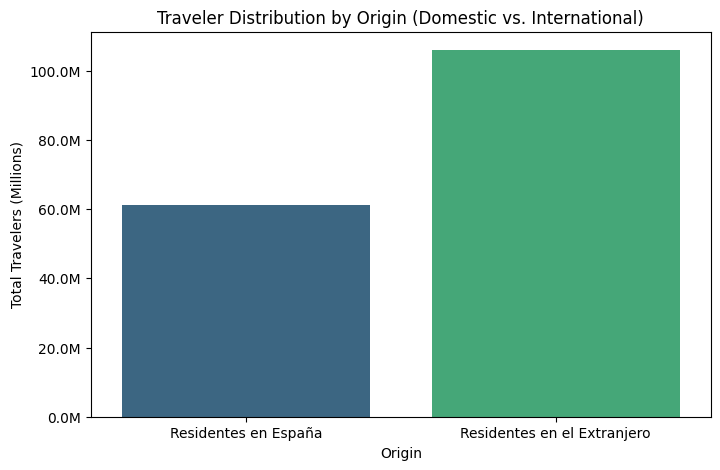

In [69]:
origin_dist = df_final.groupby('Traveler Origin')['Total Travelers'].sum().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=origin_dist, x='Traveler Origin', y='Total Travelers', palette='viridis')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

plt.title("Traveler Distribution by Origin (Domestic vs. International)")
plt.ylabel("Total Travelers (Millions)")
plt.xlabel("Origin")
plt.show()

In [71]:
origin_dist

,Traveler Origin,Total Travelers
0,Residentes en España,61317577.0
1,Residentes en el Extranjero,105995447.0


C:\Users\lasso\AppData\Local\Temp\ipykernel_2216\3605661540.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=regional_stays.index, x=regional_stays.values / 1_000_000, ax=ax1, palette='mako')
C:\Users\lasso\AppData\Local\Temp\ipykernel_2216\3605661540.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=regional_avg_stay.index, x=regional_avg_stay.values, ax=ax2, palette='rocket')


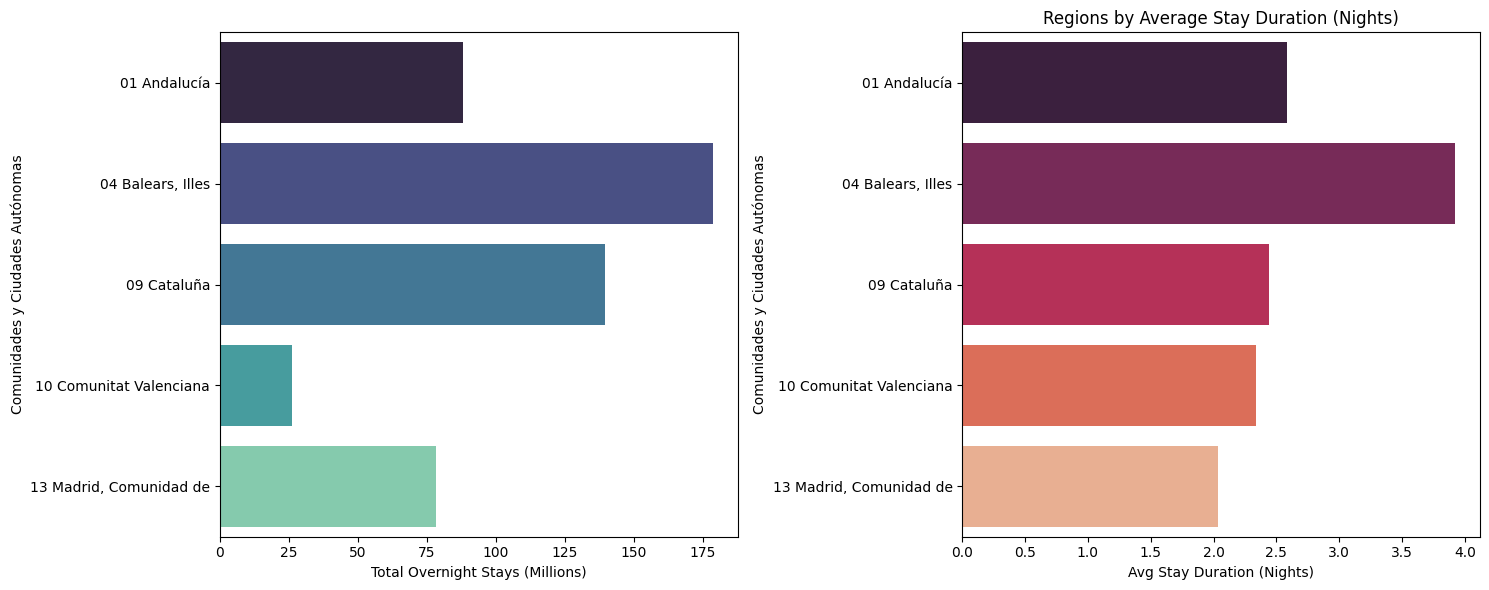

In [75]:
regional_stays = df_final.groupby('Comunidades y Ciudades Autónomas')['Total Overnight Stays'].sum()
regional_avg_stay = df_final.groupby('Comunidades y Ciudades Autónomas')['Avg Stay Duration'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(y=regional_stays.index, x=regional_stays.values / 1_000_000, ax=ax1, palette='mako')
ax1.set_xlabel("Total Overnight Stays (Millions)")  

sns.barplot(y=regional_avg_stay.index, x=regional_avg_stay.values, ax=ax2, palette='rocket')
ax2.set_title("Regions by Average Stay Duration (Nights)")
ax2.set_xlabel("Avg Stay Duration (Nights)")
plt.tight_layout()
plt.show()

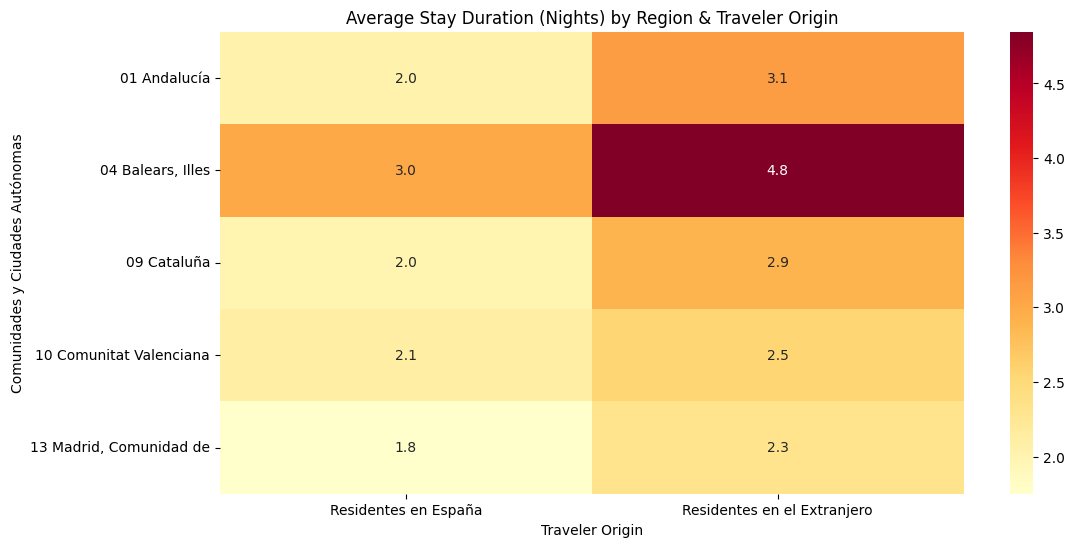

In [43]:
cross_analysis = df_final.pivot_table(
    index='Comunidades y Ciudades Autónomas',
    columns='Traveler Origin',
    values='Avg Stay Duration',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(cross_analysis, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title("Average Stay Duration (Nights) by Region & Traveler Origin")
plt.show()


    Debido a distintas actualizaciones en los directorios de establecimientos, no son directamente comparables los datos de distintos años. Existen coeficientes de enlace para los períodos: año 2005, junio2009-mayo2010, julio2010-febrero2012.
    Se ha modificado la tabla correspondiente a la publicación de enero de 2007, debido a un error detectado en la provincia de Madrid
    Establecimientos hoteleros: los datos de abril del año 2024 y posteriores son provisionales.
